In [1]:
import bs4
from bs4 import BeautifulSoup as bs
import requests
import re
import torch
import transformers
import torch.nn as nn
import torch.functional as f
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset

import pandas as pd
import numpy as np
import sklearn
import urllib
import os
import sys
import urllib.request

import datetime
from datetime import datetime
import json

import matplotlib as mpl
import matplotlib.pyplot as plt

mpl.rc('font', family='Malgun Gothic')

from wordcloud import WordCloud

from tqdm import tqdm

from sklearn.feature_extraction.text import CountVectorizer
import konlpy
from konlpy.tag import Kkma, Komoran, Okt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix, accuracy_score

from transformers import BertTokenizer

from transformers import BertConfig

C:\Users\user\miniconda3\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


beautifulsoup4


huggingface-hub==0.17.3


nltk==3.8.1


torch == 2.1.0(CPU)


transformers==4.34.1

In [2]:
dels = re.compile('&quots;|&quot;|<\/*b>|\.\.\.')

```Python
client_id = ''
client_pw = ''
encText_is= urllib.parse.quote('이스라엘')
encText_pal = urllib.parse.quote('팔레스타인')

for i in range(11):
    if i == 0:
        url = 'https://openapi.naver.com/v1/search/news?query='+encText_is+'&display=100'
    else:
        url = 'https://openapi.naver.com/v1/search/news?query='+encText_is+'&display=100&start={}00'.format(i)

    request = urllib.request.Request(url)
    request.add_header('X-Naver-Client-Id', client_id)
    request.add_header('X-Naver-Client-Secret', client_pw)

    response = urllib.request.urlopen(request)
    rescode = response.getcode()
    if rescode==200:
        response_body = response.read()
        print(response_body.decode('utf-8'))
        
    date_format = '%a, %d %b %Y %H:%M:%S %z'
        
    data = json.loads(response_body.decode('utf-8'))
    for j in range(len(data['items'])):
        df.loc[j+100*i, 'title'] = re.sub(dels, '', data['items'][j]['title'])
        df.loc[j+100*i, 'link'] = re.sub(dels, '', data['items'][j]['originallink'])
        df.loc[j+100*i, 'description'] = re.sub(dels, '', data['items'][j]['description'])
        df.loc[j+100*i, 'published_datetime'] = datetime.strptime(data['items'][j]['pubDate'], date_format)
        df.loc[j+100*i, 'published_datetime'] = df.loc[i, 'published_datetime'].replace(tzinfo=None)
        df.loc[j+100*i, 'naverlink'] = data['items'][j]['link']
        
```

In [3]:
df = pd.read_csv("./data1031.csv")

In [4]:
cs = df[df['link'].str.contains('chosun')].reset_index(drop=True) # 조선일보

hani = df[df['link'].str.contains('hani')].reset_index(drop=True) # 한겨레

khan = df[df['link'].str.contains('khan')].reset_index(drop=True) # 경향

donga = df[df['link'].str.contains('donga')].reset_index(drop=True) # 동아일보

ja = df[df['link'].str.contains('joongang')].reset_index(drop=True) # 중앙일보

In [5]:
rights = pd.concat([cs, donga, ja], axis=0)
lefts = pd.concat([hani, khan], axis=0)

rights = rights.reset_index(drop=True)
lefts = lefts.reset_index(drop=True)

In [6]:
for i in range(len(rights)):
    url = rights.loc[i, 'naverlink']
    response = requests.get(url)
    html = response.text
    
    soup = bs(html, 'lxml')
    elements = soup.select('article')
    
    rights.loc[i, 'texts'] = str(elements)

C:\Users\user\AppData\Local\Temp\ipykernel_11112\2386733686.py:9: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[<article class="go_trans _article_content" id="dic_area">
<b>산업 생산 2개월 연속 상승 <br/> 제조업 생산 회복, 반도체가 견인 <br/> 소비 ‘완만한 증가’ 보였지만, 실상은 ‘먹거리’만 증가 <br/> 건설 수주 감소에 착공도 줄어…경제 하방요인 꼽혀<br/></b><br/>        지난달 전산업 생산이 전월 대비 1.1% 늘며 2개월 연속 증가세를 이어갔다. 특히 광공업 생산은 전월 대비 1.8% 증가했다. 8월(5.2%)에 비해 증가폭은 줄었지만 기저효과를 고려하면 생산활동 회복세가 뚜렷해지고 있다는 분석이 나온다.<br/><br/>반면 소비 증가율은 0.2% 증가에 그쳤다. 추석 명절에 따른 식료품 등 비내구재 소비가 2.3% 늘었지만, 의복 등 준내구재는 2.8%, 컴퓨터와 통신기기 등 내구재는 2.3% 판매가 줄었다. 불경기에 먹거리 지출 외엔 지갑을 닫은 것이다.<br/><br/>투자 전망도 안갯속이다. 9월 설비투자는 8.7%, 건설기성이 2.5% 증가하며 호조세를 보였지만, 올해 들어 주택 착공 물량이 전년 대비 50% 이상 감소한 게 건설기성에도 반영될 전망이다. 9월 산업활동동향에서도 건축 건설기성은 일부 아파트 대단지 준공이 완료되면서 2.7% 감소한 것으로 집계됐다.<br/><br/><span class="end_photo_org"><div class="nbd_im_w _LAZY_LOADING_WRAP">
<div class="nbd_a _LAZY_LOADING_ERROR_HIDE" id="img_a1">
<img class="_LAZY_LOADING

In [7]:
for i in range(len(lefts)):
    url = lefts.loc[i, 'naverlink']
    response = requests.get(url)
    html = response.text
    
    soup = bs(html, 'lxml')
    elements = soup.select('article')
    
    lefts.loc[i, 'texts'] = str(elements)

C:\Users\user\AppData\Local\Temp\ipykernel_11112\4102319831.py:9: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[<article class="go_trans _article_content" id="dic_area">
<span class="end_photo_org"><div class="nbd_im_w _LAZY_LOADING_WRAP">
<div class="nbd_a _LAZY_LOADING_ERROR_HIDE" id="img_a1">
<img class="_LAZY_LOADING" data-src="https://imgnews.pstatic.net/image/028/2023/10/31/0002662526_001_20231031192304698.jpg?type=w647" id="img1"/>
</div>
</div><em class="img_desc">해상 석유시추시설이 미국 앨라배마 도핀 섬 근처 바다에 서 있다. 2013년 10월 5일 촬영. 로이터 연합뉴스</em></span><br/><br/>이스라엘과 하마스의 전쟁이 확대되면 “석유값이 천정부지로 뛰어오를 수 있다”고 세계은행이 경고했다.<br/><br/>세계은행은 30일 공개한 ‘원자재시장전망’ 보고서에서 “중동 전쟁이 확대되지 않으면 유가에 미치는 영향이 제한적이지만, 더 확대되면 유가 전망이 급격히 어두워질 것”이라고 밝혔다. 지난 7일 무력충돌이 일어난 이후 유가는 약 6%, 전쟁 같은 혼란기에 각광받는 금은 8% 남짓 올랐다.<br/><br/>세계은행은 향후 유가시장 전망과 관련해선 세 가지 시나리오를 내놓았다. 중동 전쟁이 더 확대되지 않아 ‘작은 교란’만 있는 첫 번째 시나리오에선, 현재 배럴당 90달러 수준인 유가가 내년 세계 경제 둔화의 영향으로 81달러까지 떨어질 것

In [8]:
rights_txt = rights['title'] + rights['description'] + rights['texts']

In [9]:
lefts_txt = lefts['title'] + lefts['description'] + lefts['texts']

In [10]:
ctright = CountVectorizer()
ctleft = CountVectorizer()

rights_words = ctright.fit_transform(rights_txt)

lefts_words = ctleft.fit_transform(lefts_txt)

In [11]:
rights_words = pd.DataFrame(rights_words.toarray(), columns=ctright.get_feature_names_out())
lefts_words = pd.DataFrame(lefts_words.toarray(), columns=ctleft.get_feature_names_out())

In [12]:
okt = Okt()

In [13]:
okt.pos(rights_words.columns[1])

[('000', 'Number')]

In [14]:
for i in rights_words.columns:
    tags = okt.pos(i)
    
    if tags[0][1] not in ['Noun']:
        rights_words.drop(columns = i, inplace=True)

In [15]:
for i in lefts_words.columns:
    tags = okt.pos(i)
    
    if tags[0][1] not in ['Noun']:
        lefts_words.drop(columns = i, inplace=True)

In [16]:
right_counts = rights_words.sum().sort_values(ascending=False)

In [17]:
left_counts = lefts_words.sum().sort_values(ascending=False)

In [18]:
rights_dict = {
    
}
lefts_dict = {
    
}

for i in right_counts.index:
    noun = okt.pos(i)[0][0]
    if len(noun)>=2:
        try:
            if noun in rights_dict.keys():
                rights_dict[noun] += right_counts[noun]
            else:
                rights_dict[noun] = right_counts[noun]
        except:
            continue
            
for i in left_counts.index:
    noun = okt.pos(i)[0][0]
    if len(noun)>=2:
        try:
            if noun in lefts_dict.keys():
                lefts_dict[noun] += left_counts[noun]
            else:
                lefts_dict[noun] = left_counts[noun]
        except:
            continue

In [19]:
rights_dict

{'이스라엘': 4536,
 '하마스': 1668,
 '미국': 2478,
 '팔레스타인': 763,
 '지난': 103,
 '대한': 100,
 '가자지구': 837,
 '네타냐후': 288,
 '위해': 210,
 '북한': 1650,
 '전쟁': 1260,
 '통해': 124,
 '우리': 671,
 '경제': 798,
 '최근': 275,
 '세계': 935,
 '친북': 212,
 '댓글': 260,
 '이후': 459,
 '이스라엘군': 450,
 '중동': 564,
 '글로벌': 46,
 '정부': 434,
 '대통령': 190,
 '현지': 120,
 '가운데': 42,
 '가장': 41,
 '한국': 760,
 '바이든': 156,
 '연합뉴스': 38,
 '여성': 370,
 '러시아': 370,
 '무장': 444,
 '안보': 324,
 '경우': 252,
 '민간인': 180,
 '총리': 24,
 '오전': 36,
 '당시': 140,
 '우크라이나': 350,
 '정보': 374,
 '인질': 363,
 '모든': 33,
 '베냐민': 31,
 '배럴': 16,
 '이번': 174,
 '석유': 145,
 '투자': 522,
 '단체': 448,
 '윤석열': 26,
 '최대': 104,
 '지상': 234,
 '올해': 78,
 '더욱': 26,
 '다른': 52,
 '주요': 26,
 '현재': 200,
 '원자재': 50,
 '국회': 250,
 '시각': 75,
 '여러': 25,
 '앞서': 23,
 '반도체': 115,
 '국가': 483,
 '민주당': 92,
 '샤니': 112,
 '민생': 176,
 '공격': 546,
 '수요': 24,
 '무기': 286,
 '기술': 176,
 '또한': 21,
 '병원': 168,
 '국제': 483,
 '물가': 210,
 '트위터': 20,
 '예산안': 140,
 '서울': 80,
 '크게': 19,
 '북부': 95,
 '사망': 120,
 '무력': 171,
 '다만'

In [20]:
lefts_dict

{'이스라엘': 288,
 '통해': 26,
 '대한': 25,
 '네타냐후': 23,
 '우리': 126,
 '위해': 20,
 '하마스': 152,
 '세계': 180,
 '전쟁': 80,
 '정부': 49,
 '지난': 17,
 '경제': 119,
 '대통령': 10,
 '글로벌': 14,
 '인질': 143,
 '가자지구': 91,
 '안보': 26,
 '이후': 24,
 '예산': 72,
 '우크라이나': 11,
 '총리': 4,
 '예산안': 77,
 '팔레스타인': 11,
 '최근': 20,
 '이번': 30,
 '민생': 50,
 '일부': 10,
 '여러분': 18,
 '더욱': 9,
 '가운데': 9,
 '베냐민': 9,
 '휴전': 48,
 '여성': 48,
 '지상': 32,
 '중동': 16,
 '면서': 8,
 '기술': 24,
 '올해': 16,
 '유엔': 48,
 '다시': 8,
 '보호': 24,
 '재정': 32,
 '국가': 63,
 '여군': 7,
 '미래': 28,
 '유가': 20,
 '영상': 15,
 '경우': 28,
 '인도주의': 2,
 '대해': 6,
 '러시아': 14,
 '공개': 5,
 '의원': 14,
 '또한': 7,
 '교권': 6,
 '작전': 30,
 '이태원': 30,
 '국민': 42,
 '하루': 6,
 '내년': 30,
 '모든': 6,
 '한편': 6,
 '원자재': 12,
 '지출': 18,
 '지금': 18,
 '국회': 30,
 '명의': 6,
 '오리': 5,
 '연설': 25,
 '성장': 25,
 '시장': 20,
 '윤석열': 5,
 '확대': 10,
 '구호': 24,
 '매우': 5,
 '모습': 9,
 '물가': 15,
 '독일': 4,
 '국제': 15,
 '협력': 6,
 '교육': 35,
 '반도체': 10,
 '첨단': 10,
 '국방': 4,
 '양자': 4,
 '다른': 4,
 '약자': 12,
 '앞서': 4,
 '당장': 4,
 '대한민국': 4,
 '여야

In [21]:
stop_words = ['우리', '대한', '위해', '통해', '최근', '이후', '가운데', '가장', '경우', '당시', '오전', '이번', '더욱', '다른', '면서', '여러분', '다시']

In [22]:
for i in stop_words:
    try:
        del rights_dict[i]
    except:
        continue
        
    try:
        del lefts_dict[i]
    except:
        continue

In [23]:
font_path = 'C:/Windows/Fonts/맑은 고딕/malgun.ttf'

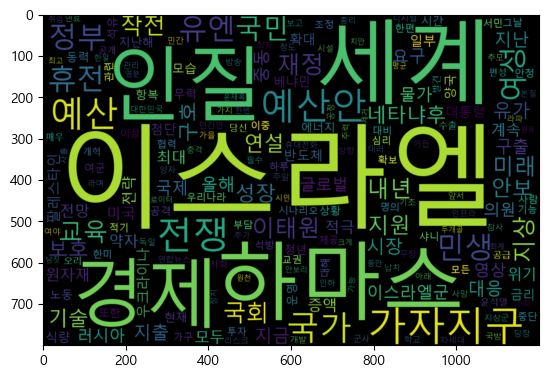

In [24]:
wordcloud_left = WordCloud(font_path = font_path,
                      background_color='black',
                      width=1200,
                      height=800).generate_from_frequencies(lefts_dict)

plt.imshow(wordcloud_left, interpolation='bilinear')

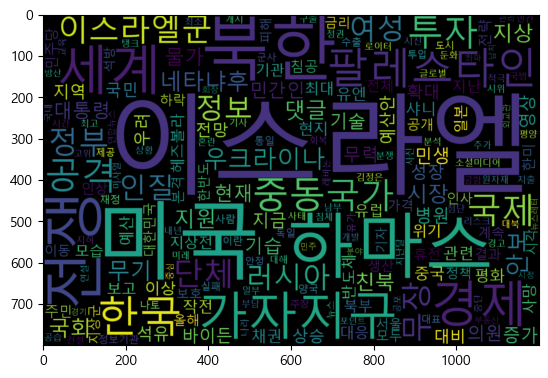

In [25]:
wordcloud_right = WordCloud(font_path = font_path,
                      background_color='black',
                      width=1200,
                      height=800).generate_from_frequencies(rights_dict)

plt.imshow(wordcloud_right, interpolation='bilinear')

상대적으로 right 경향의 신문사에서는 북한, 미국, 팔레스타인, 러시아, 가자지구의 단어가 빈번하게 도출. 

left 계열의 신문사에서는 상대적으로 예산, 연설, 교육, 미래, UN, 민생, 보호, 구호 등의 키워드가 도출.

In [26]:
sorted_right = sorted(rights_dict.values(), reverse=True)

In [27]:
left = pd.DataFrame()
num = 0
for i in lefts_dict.keys():
    left.loc[num, 'key'] = i
    left.loc[num, 'value'] = lefts_dict[i]
    num += 1

C:\Users\user\AppData\Local\Temp\ipykernel_11112\3568222503.py:4: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '이스라엘' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  left.loc[num, 'key'] = i


In [28]:
right = pd.DataFrame()
num = 0
for i in rights_dict.keys():
    right.loc[num, 'key'] = i
    right.loc[num, 'value'] = rights_dict[i]
    num += 1

C:\Users\user\AppData\Local\Temp\ipykernel_11112\173499584.py:4: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '이스라엘' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  right.loc[num, 'key'] = i


In [29]:
right = right.sort_values('value', ascending=False).reset_index(drop=True)

In [30]:
left = left.sort_values('value', ascending=False).reset_index(drop=True)

In [31]:
intersection = set(left['key'].head(30)) & set(right['key'].head(30))

In [32]:
intersection

{'가자지구',
 '경제',
 '국가',
 '국회',
 '세계',
 '안보',
 '여성',
 '이스라엘',
 '인질',
 '전쟁',
 '정부',
 '지원',
 '하마스'}

언급량 톱 30 중, 교차를 빼고 각각의 신문사에서 중요했던 단어들 추출

In [33]:
set(left['key'].head(30))-intersection

{'교육',
 '국민',
 '기술',
 '내년',
 '미래',
 '민생',
 '보호',
 '성장',
 '연설',
 '예산',
 '예산안',
 '유엔',
 '이태원',
 '작전',
 '재정',
 '지상',
 '휴전'}

In [34]:
set(right['key'].head(30))-intersection

{'공격',
 '국제',
 '네타냐후',
 '단체',
 '댓글',
 '러시아',
 '무기',
 '무장',
 '미국',
 '북한',
 '우크라이나',
 '이스라엘군',
 '정보',
 '중동',
 '투자',
 '팔레스타인',
 '한국'}

In [35]:
intersection_50 = set(left['key'].head(50)) & set(right['key'].head(50))

In [36]:
intersection_50

{'가자지구',
 '경제',
 '국가',
 '국제',
 '국회',
 '기술',
 '네타냐후',
 '러시아',
 '물가',
 '민생',
 '성장',
 '세계',
 '시장',
 '안보',
 '여성',
 '영상',
 '의원',
 '이스라엘',
 '이스라엘군',
 '인질',
 '전쟁',
 '정부',
 '중동',
 '지금',
 '지상',
 '지원',
 '하마스'}

In [37]:
set(left['key'].head(50))-intersection_50

{'교육',
 '구출',
 '구호',
 '국민',
 '글로벌',
 '내년',
 '대응',
 '미래',
 '보호',
 '연설',
 '예산',
 '예산안',
 '올해',
 '요구',
 '위기',
 '유가',
 '유엔',
 '이태원',
 '작전',
 '재정',
 '지난',
 '지출',
 '휴전'}

In [38]:
set(right['key'].head(50))-intersection_50

{'공격',
 '기습',
 '단체',
 '대통령',
 '댓글',
 '무기',
 '무력',
 '무장',
 '미국',
 '민간인',
 '바이든',
 '병원',
 '북한',
 '석유',
 '우려',
 '우크라이나',
 '정보',
 '증가',
 '친북',
 '투자',
 '팔레스타인',
 '한국',
 '현재'}

In [39]:
for i in range(len(rights)):
    rights.loc[i, 'title'] = '[CLS]' + rights.loc[i, 'title']+'[SEP]'
    rights.loc[i, 'description'] = '[CLS]'+rights.loc[i, 'description']+'[SEP]'
    rights.loc[i, 'texts'] = '[CLS]'+re.sub(r'<[^>]+>|\n|\/', '', rights.loc[i, 'texts'])+'[SEP]'

In [40]:
for i in range(len(lefts)):
    lefts.loc[i, 'title'] = '[CLS]' + lefts.loc[i, 'title']+'[SEP]'
    lefts.loc[i, 'description'] = '[CLS]'+lefts.loc[i, 'description']+'[SEP]'
    lefts.loc[i, 'texts'] = '[CLS]'+re.sub(r'<[^>]+>|\n|\/', '', lefts.loc[i, 'texts'])+'[SEP]'

In [41]:
hk = lefts['title']+lefts['description']+lefts['texts']

In [42]:
ccd = rights['title']+rights['description']+rights['texts']

In [43]:
ccd = pd.DataFrame(ccd, columns=['text'])
hk = pd.DataFrame(hk, columns=['text'])

In [44]:
hk['label'] = 0
ccd['label'] = 1

In [45]:
textdata = pd.concat([hk, ccd], axis=0)

In [46]:
textdata

,text,label
0,[CLS]세계은행 “중동 전쟁 확대되면 유가 56~75% 치솟을 것”[SEP][CL...,0
1,[CLS]이스라엘 “휴전은 없다”…유엔 요구 사흘 만에 거부[SEP][CLS]베냐민...,0
2,[CLS]윤 대통령 “예산 23조 줄여 재원 확보…물가·민생 총력” [전문][SEP...,0
3,[CLS]가을엔 떠나지 말아요…그날 사고는 당신들 탓 아니다[SEP][CLS]이태원...,0
4,"[CLS]구출된 여군, 결국 사망한 독일계 여성…생사 엇갈리는 인질들[SEP][CL...",0
...,...,...
67,[CLS][사진] 포연 속 가자시티 … 놀란 비둘기[SEP][CLS]29일 이스라엘...,1
68,"[CLS]석방 협상해라 네타냐후에 울부짖는 女…하마스, 인질 영상 또 공개[SEP]...",1
69,[CLS]중동전 확전 조짐에…고금리 더 길어지나[SEP][CLS]한국의 물가 둔화 ...,1
70,"[CLS]국내외 안팎에서 치이는 바이든…지지율 하락, 이스라엘은 ‘마이웨이’[SEP...",1


In [47]:
textdata=textdata.reset_index(drop=True)

In [48]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [50]:
config = BertConfig.from_pretrained('monologg/kobert')

tokenizer = BertTokenizer.from_pretrained('monologg/kobert')


In [51]:
textdata

,text,label
0,[CLS]세계은행 “중동 전쟁 확대되면 유가 56~75% 치솟을 것”[SEP][CL...,0
1,[CLS]이스라엘 “휴전은 없다”…유엔 요구 사흘 만에 거부[SEP][CLS]베냐민...,0
2,[CLS]윤 대통령 “예산 23조 줄여 재원 확보…물가·민생 총력” [전문][SEP...,0
3,[CLS]가을엔 떠나지 말아요…그날 사고는 당신들 탓 아니다[SEP][CLS]이태원...,0
4,"[CLS]구출된 여군, 결국 사망한 독일계 여성…생사 엇갈리는 인질들[SEP][CL...",0
...,...,...
80,[CLS][사진] 포연 속 가자시티 … 놀란 비둘기[SEP][CLS]29일 이스라엘...,1
81,"[CLS]석방 협상해라 네타냐후에 울부짖는 女…하마스, 인질 영상 또 공개[SEP]...",1
82,[CLS]중동전 확전 조짐에…고금리 더 길어지나[SEP][CLS]한국의 물가 둔화 ...,1
83,"[CLS]국내외 안팎에서 치이는 바이든…지지율 하락, 이스라엘은 ‘마이웨이’[SEP...",1


In [52]:
tokenized = pd.DataFrame()

with torch.no_grad():
    for idx in tqdm(range(len(textdata))):
        row = textdata.iloc[idx, 0]
        inputs = tokenizer(row, padding='max_length', truncation=True, max_length = 256, pad_to_max_length = True, return_tensors="pt", )
        for j in range(len(inputs['input_ids'][0])):
            tokenized.loc[idx,j] = int(inputs['input_ids'][0][j])

  0%|                                                                                           | 0/85 [00:00<?, ?it/s]C:\Users\user\AppData\Local\Temp\ipykernel_11112\960612589.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  tokenized.loc[idx,j] = int(inputs['input_ids'][0][j])
100%|██████████████████████████████████████████████████████████████████████████████████| 85/85 [00:03<00:00, 28.15it/s]


In [53]:
tokenized

,0,1,2,3,4,5,6,7,8,9,...,246,247,248,249,250,251,252,253,254,255
0,2.0,2.0,0.0,501.0,0.0,7215.0,0.0,0.0,184.0,463.0,...,0.0,0.0,46.0,0.0,184.0,463.0,214.0,11.0,0.0,3.0
1,2.0,2.0,0.0,501.0,0.0,0.0,502.0,0.0,0.0,0.0,...,7828.0,0.0,0.0,0.0,0.0,54.0,0.0,501.0,0.0,3.0
2,2.0,2.0,7068.0,5821.0,501.0,6959.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,54.0,7068.0,0.0,501.0,0.0,0.0,3.0
3,2.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,7595.0,...,0.0,54.0,502.0,18.0,0.0,0.0,0.0,0.0,0.0,3.0
4,2.0,2.0,0.0,0.0,46.0,0.0,0.0,0.0,6923.0,0.0,...,0.0,0.0,0.0,0.0,6923.0,0.0,6097.0,18.0,134.0,3.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
80,2.0,2.0,362.0,6511.0,363.0,0.0,6615.0,0.0,0.0,0.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
81,2.0,2.0,0.0,0.0,0.0,0.0,5265.0,0.0,0.0,46.0,...,7127.0,0.0,8.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0
82,2.0,2.0,0.0,0.0,0.0,0.0,0.0,5837.0,0.0,3.0,...,18.0,148.0,54.0,157.0,11.0,40.0,6372.0,0.0,0.0,3.0
83,2.0,2.0,5506.0,0.0,0.0,0.0,0.0,0.0,0.0,46.0,...,0.0,0.0,7143.0,54.0,6255.0,0.0,0.0,0.0,0.0,3.0


In [196]:
xtr, xte, ytr, yte = train_test_split(tokenized, textdata['label'], test_size=0.25, stratify=textdata['label'])

In [197]:
def logistic_tuning(train_sprs, y, params):
    model = LogisticRegression(random_state=0)
    grid = GridSearchCV(model, params, scoring='accuracy', cv=5)
    grid.fit(train_sprs, y)
    
    print('best param: ', grid.best_params_)
    print('best_score: ', grid.best_score_)
    
    return grid.best_estimator_

In [198]:
param1 = {'penalty':['l1', 'l2'], 'C':[0.01, 0.05, 0.1, 0.2, 0.001, 1, 2, 5, 10], 'max_iter': [100, 300]}

In [199]:
logistic_tuning(xtr, ytr, param1)

best param:  {'C': 0.01, 'max_iter': 100, 'penalty': 'l2'}
best_score:  0.8243589743589744


C:\Users\user\miniconda3\Lib\site-packages\sklearn\model_selection\_validation.py:425: FitFailedWarning: 
90 fits failed out of a total of 180.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
90 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\user\miniconda3\Lib\site-packages\sklearn\model_selection\_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\user\miniconda3\Lib\site-packages\sklearn\base.py", line 1152, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\user\miniconda3\Lib\site-packages\sklearn\linear_model\_logistic.py", line 1169, in fit
    solver = 

LogisticRegression(C=0.01, random_state=0)

In [200]:
params = {'C': [0.01], 'max_iter': [100], 'penalty': ['l2']}

In [201]:
model = logistic_tuning(xtr, ytr, params=params)

best param:  {'C': 0.01, 'max_iter': 100, 'penalty': 'l2'}
best_score:  0.8243589743589744


In [202]:
preds = model.predict(xte)

In [203]:
acs = accuracy_score
cm = confusion_matrix

In [204]:
print(cm(preds, yte))

[[ 0  1]
 [ 3 18]]


In [205]:
print(acs(preds, yte))

0.8181818181818182


In [206]:
preds_train = model.predict(xtr)

In [207]:
print(cm(preds_train, ytr))

[[10  0]
 [ 0 53]]


In [208]:
print(acs(preds_train, ytr))

1.0
